want to roll a FWTD. Will stick a FWTD at both ends of a rigid beam that can rotate freely

### Preamble

In [1]:
import sympy as sym
import sympy.physics.mechanics as me
import pandas as pd
import seaborn as sns

import numpy as np
from scipy.integrate import odeint,LSODA,BDF,solve_ivp
import matplotlib.pyplot as plt

import sys, os

sys.path.insert(1, os.path.join(sys.path[0], '../..'))
import ModelFramework as mf
import ModelFramework.Elements as ele
import ModelFramework.ExternalForces as ef

me.mechanics_printing()

### Define the Model

#### Create Parameter instance

In [2]:
half = sym.Rational(1,2)

p = mf.ModelParameters.DynamicModel(3)

# fwt params
p.Lambda = mf.ModelVariable(np.deg2rad(10),'Lambda') # flare angle
p.y_f = sym.Symbol('y_f')# spanwise location
    
# Attitude Parmas
p.rho = mf.ModelVariable(1.225,'rho') # density
p.V = mf.ModelVariable(10,'V') # velocity
p.g  = mf.ModelVariable(9.81,'g') # gravity
p.alpha_r = mf.ModelVariable(np.deg2rad(3),'alpha_r') # root AoA

# Main Wing Parameter
p.a_w = mf.ModelVariable(2*np.pi,'a_w') # C_L of wing
p.y_w = sym.Symbol('y_w') # spanwise location


# Create some global parameters
p.c = mf.ModelVariable(0.067,'c') # chord of wing
#p.m_t = mf.ModelVariable(2,'m_t') # wing total mass
p.s_t = mf.ModelVariable(1,'s_t') # wing total span
p.sigma = mf.ModelVariable(7/25,'sigma') # FWT as percentage of total span
#p.f = mf.ModelVariable(2,'f') # initial freqency


# Set dependent expressions
p.m_w = mf.ModelVariable(0.22,'m_w') # density # mass of inner wing
p.s_w = p.s_t*(sym.Integer(1)-p.sigma) # span of main wing
p.m_f = mf.ModelVariable(0.038,'m_f') # mass of each FWT
p.s_f = p.s_t*p.sigma*half # span of each FWT

#p.a_f_0 = mf.ModelVariable(np.pi*2,'a_f0')
#p.a_f_grad = mf.ModelVariable((2*np.pi)/1*0.2*0.5,'a_f_grad')
p.a_f = 2*sym.pi - 2*sym.pi/p.s_f*p.y_f #p.a_f_0 - p.a_f_grad*p.y_f


p.I_xx_f = sym.Rational(1,12)*p.m_f*p.s_f**2 # inertia of FWT (uniform bar)
p.I_xx_w = sym.Rational(1,12)*p.m_w*p.s_w**2 # inertia of wing (uniform bar)
p.l_f = p.s_f*half # location of FWT CoM from Hinge
p.l_w = 0 # location of main wing CoM

p.aoa_rhs = mf.ModelVariable(0,'alpha_rhs') # chord of wing
p.aoa_lhs = mf.ModelVariable(0,'alpha_lhs') # chord of wing

#### Create Transforms

system has 3 degrees of freedom:

q[0] - rotation about the base of the spring (roll)
q[1] - plunging motion
q[2] - FWT fold angle



In [3]:
wing_frame = mf.HomogenousTransform().R_x(p.q[0]).R_y(p.alpha_r)
rhs_fwt_frame = wing_frame.Translate(0,p.s_w*half,0).R_x(-p.q[1])  # RHS Fwt Frame
lhs_fwt_frame = wing_frame.Translate(0,-p.s_w*half,0).R_x(p.q[2])  # RHS Fwt Frame

M_fwt = ele.MassMatrix(p.m_f,I_xx = p.I_xx_f)
M_w = ele.MassMatrix(p.m_w,I_xx = p.I_xx_w)

bar_fwt_rhs = ele.RigidElement(rhs_fwt_frame.Translate(0,p.l_f,0),M_fwt,True)
bar_fwt_lhs = ele.RigidElement(lhs_fwt_frame.Translate(0,-p.l_f,0),M_fwt,True)
bar_wing = ele.RigidElement(wing_frame,M_w)

# Gravitational Forces
#fwt_GravityForces_rhs = ef.GravityForce(p,rhs_fwt_frame.Translate(0,p.l_f,0),sym.Matrix([0,0,-p.g*p.m_f]))
#fwt_GravityForces_lhs = ef.GravityForce(p,lhs_fwt_frame.Translate(0,-p.l_f,0),sym.Matrix([0,0,-p.g*p.m_f]))
#wing_GravityForces = ef.GravityForce(p,wing_frame,sym.Matrix([0,0,-p.g*p.m_w]))
#Aero Forces
rhs_fwt_AeroForces = ef.AeroForce(p,rhs_fwt_frame.Translate(0,p.y_f,0),p.a_f,(p.y_f,0,p.s_f),p.aoa_rhs,0,0,0,0)
lhs_fwt_AeroForces = ef.AeroForce(p,lhs_fwt_frame.Translate(0,-p.y_f,0),p.a_f,(p.y_f,0,p.s_f),p.aoa_lhs,0,0,0,0)

In [5]:
wing_frame_aero = wing_frame.Translate(0,p.y_w,0)
wing_AeroForces = ef.AeroForce(p,wing_frame_aero,p.a_w,(p.y_w,-p.s_w*half,p.s_w*half),p.alpha_r,0,0,0,0)

Forcing = ef.CustomForce(None) 

CompositeForce = ef.CompositeForce(p,[rhs_fwt_AeroForces,lhs_fwt_AeroForces,
                                     wing_AeroForces,Forcing])

In [7]:
from inspect import getsource
getsource(wing_AeroForces.q_func) + 'hello'

'def _lambdifygenerated(_Dummy_286, _Dummy_287):\n    [Lambda, rho, V, g, alpha_r, a_w, c, s_t, sigma, m_w, m_f, alpha_rhs, alpha_lhs] = _Dummy_286\n    [_Dummy_285, _Dummy_282, _Dummy_284, _Dummy_281, _Dummy_283, _Dummy_280] = _Dummy_287\n    return (array([[-1/24*_Dummy_282*V*a_w*c*rho*s_t**3*(1 - sigma)**3*cos(alpha_r)**2], [0], [0]]))\nhello'

In [ ]:
# create instance of the model
sm = mf.SymbolicModel.FromElementsAndForces(p,[bar_fwt_rhs,bar_fwt_lhs,bar_wing],ExtForces = CompositeForce)

## create masses 

In [106]:
tmax, dt = 120, 0.01
# Initial conditions: theta, dtheta/dt, L, dL/dt

#params = p.GetNumericTuple()

#set velocity and alpha_r funcs
def Vfunc(t,x):
    return 30

def arfunc(t,x):
    return np.deg2rad(4)
    #return np.deg2rad(5)+np.sin(2*np.pi*1*t)*np.deg2rad(5)

def Force(tup,x,t):
    val = 0.7
    #if t<5:
       #return np.array([[0],[0],[0]])
    #if t<10:
        #return np.array([[val*(t-5)/5],[0],[0]])
    return np.array([[val],[0],[0]])

Forcing.Forcingfunction = Force
    

p.V.value = Vfunc
p.alpha_r.value = arfunc

rhs_aoa = sym.lambdify((p.alpha_r,p.x),mf.GetAoA(p.alpha_r,0,p.Lambda.value,p.q[1]))
lhs_aoa = sym.lambdify((p.alpha_r,p.x),mf.GetAoA(p.alpha_r,0,p.Lambda.value,p.q[2]))

p.aoa_rhs.value = lambda t,x:rhs_aoa(arfunc(t,x),x)
p.aoa_lhs.value = lambda t,x:lhs_aoa(arfunc(t,x),x)


#y0 = [1.57,0,0,0,0,0]
#y0 = [1.5,0,0.02,0]
ts = np.arange(0, tmax+dt, dt)

#constraints = [0,0,np.NaN,np.NaN,np.NaN,np.NaN]
y0 = [0,0,0.18,0,0.18,0]

constraints = [np.NaN,np.NaN,np.NaN,np.NaN,np.NaN,np.NaN]
constraints = [np.NaN,np.NaN,0,0,0,0]

def objectiveDeriv(t,y):
    deriv = list(sm.deriv(t,y,p.GetNumericTuple(y,t)))
    return tuple(np.where(np.isnan(constraints),deriv,constraints))

In [107]:
yData = solve_ivp(objectiveDeriv,(0,tmax),y0)

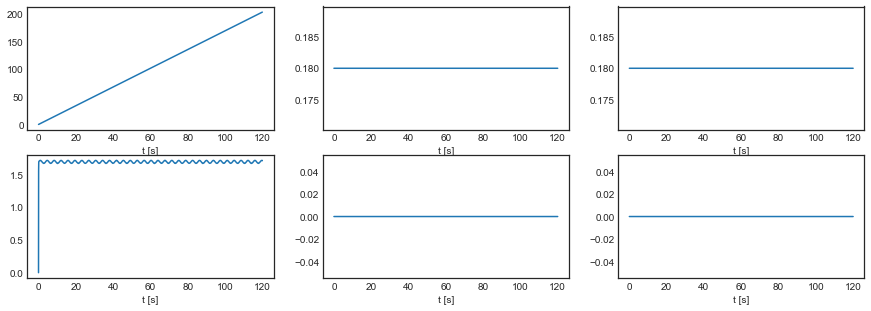

In [108]:
yi = yData.y
t = yData.t

plt.style.use('seaborn-white')

  
fig, axes = plt.subplots(2,int(len(yi)/2),figsize=(15,5))

for i in range(int(len(yi)/2)):
    # pos plot
    axes[0][i].plot(t,yi[i*2])
    axes[0][i].set_ylabel('')
    axes[0][i].set_xlabel('t [s]')
    
    # vel plot
    axes[1][i].plot(t,yi[i*2+1])
    axes[1][i].set_ylabel('')
    axes[1][i].set_xlabel('t [s]')

Text(0.5, 0, 't [s]')

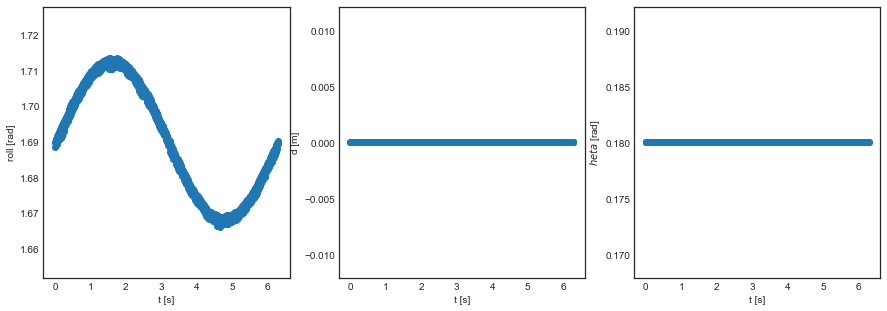

In [109]:
fig, axes = plt.subplots(1,3,figsize=(15,5))

# roll plot
ind = yi[0]>np.pi*10

axes[0].scatter(yi[0][ind]%(2*np.pi),yi[1][ind])
axes[0].set_ylabel('roll [rad]')
axes[0].set_xlabel('t [s]')

# d plot
axes[1].scatter(yi[0][ind]%(2*np.pi),yi[3][ind])
axes[1].set_ylabel('d [m]')
axes[1].set_xlabel('t [s]')

# theta plot
axes[2].scatter((yi[0][ind])%(2*np.pi),yi[4][ind])
axes[2].set_ylabel('$\theta$ [rad]')
axes[2].set_xlabel('t [s]')


In [133]:
F = sym.Symbol('F')
roll_accel = (sm.M*p.qdd + sm.f + CompositeForce.Q() + sym.Matrix([F,0,0])).subs({p.q[2]:0,p.qd[1]:0,p.qd[2]:0,p.alpha_r:0})[0]

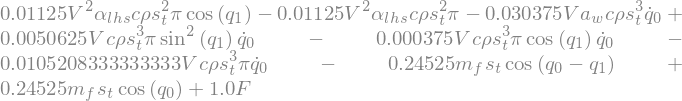

In [135]:
sym.simplify(roll_accel).subs({p.aoa_rhs:p.aoa_lhs,p.qdd[0]:0,p.sigma:0.1})